In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import re
import emoji
import nltk
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [75]:
CONFIG = {
    'test_size': 0.2,
    'random_state': 42,
    'tfidf_max_features': 30, 
    'ngram_range': (1, 2),
    'cv_folds': 5
}

for key, value in CONFIG.items():
    print(f"  {key}: {value}")

  test_size: 0.2
  random_state: 42
  tfidf_max_features: 30
  ngram_range: (1, 2)
  cv_folds: 5


Dataset shape: (11949, 3)
Columns: ['ID', 'comments', 'label']

 Null values:
ID          0
comments    0
label       0
dtype: int64

 Label distribution:
label
1    7898
0    4051
Name: count, dtype: int64


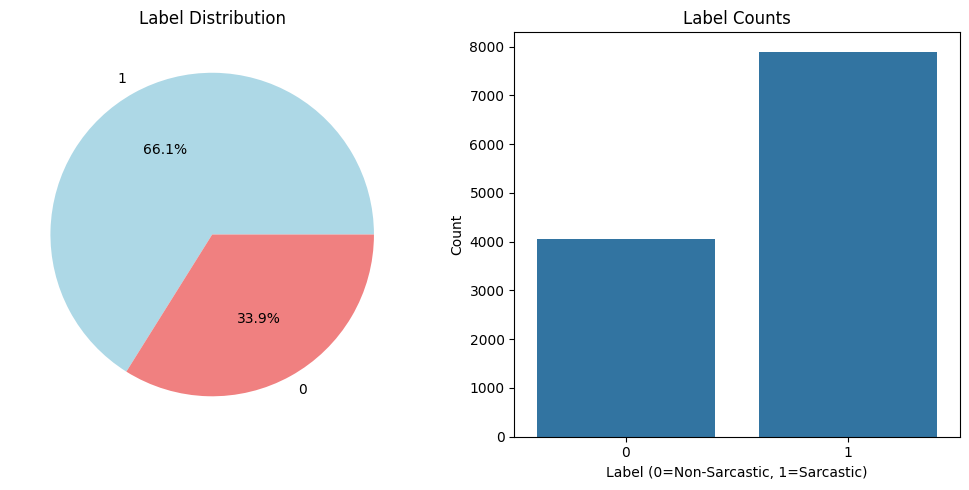

In [67]:
df = pd.read_csv('/teamspace/studios/this_studio/Sarcasm Detection/combined_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

print(f"\n Null values:")
print(df.isnull().sum())

# Basic info about the dataset
print(f"\n Label distribution:")
label_counts = df['label'].value_counts()
print(label_counts)

# Plot label distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Label Distribution')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='label')
plt.title('Label Counts')
plt.xlabel('Label (0=Non-Sarcastic, 1=Sarcastic)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [69]:
class TextPreprocessor:
    def __init__(self):
        self.hindi_stopwords = set(['hai', 'hain', 'ho', 'ka', 'ki', 'ko', 'se', 'mein', 'par', 'aur', 'yeh', 'woh'])
    
    def remove_urls(self, text):
        return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    def remove_mentions(self, text):
        return re.sub(r'@\w+', '', text)
    
    def remove_hashtags(self, text):
        return re.sub(r'#', '', text)
    
    def handle_emojis(self, text):
        return emoji.demojize(text, delimiters=(" ", " "))
    
    def normalize_elongations(self, text):
        return re.sub(r"(.)\1{3,}", r"\1\1\1", text)
    
    def clean_text(self, text):
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def preprocess_text(self, text):
        if not isinstance(text, str):
            return ""
            
        text = self.remove_urls(text)
        text = self.remove_mentions(text)
        text = self.remove_hashtags(text)
        text = self.handle_emojis(text)
        text = self.normalize_elongations(text)
        text = text.lower()
        text = self.clean_text(text)
        return text

preprocessor = TextPreprocessor()
df['processed_text'] = df['comments'].apply(preprocessor.preprocess_text)

In [72]:
print("Text Statistics Analysis...")

df['text_length'] = df['processed_text'].apply(len)
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))
from collections import Counter
all_words = ' '.join(df['processed_text']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

words, counts = zip(*common_words)

print(f"Text Statistics Summary:")
print(f"Average text length: {df['text_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")
print(f"Max text length: {df['text_length'].max()} characters")
print(f"Min text length: {df['text_length'].min()} characters")

Text Statistics Analysis...
Text Statistics Summary:
Average text length: 80.13 characters
Average word count: 13.59 words
Max text length: 239 characters
Min text length: 6 characters


In [76]:
X = df['processed_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=CONFIG['test_size'], 
    random_state=CONFIG['random_state'],
    stratify=y
)

In [77]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=CONFIG['tfidf_max_features'],
    ngram_range=CONFIG['ngram_range'],
    stop_words='english',
    min_df=2, 
    max_df=0.8 
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"X_train_tfidf shape: {X_train_tfidf.shape}")
print(f"X_test_tfidf shape: {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

X_train_tfidf shape: (9559, 30)
X_test_tfidf shape: (2390, 30)
Vocabulary size: 30


In [80]:
def extract_linguistic_features(texts):
    features = []
    for text in texts:
        feature_dict = {}
        
        feature_dict['text_length'] = len(text)
        feature_dict['word_count'] = len(text.split())
        
        feature_dict['exclamation_count'] = text.count('!')
        feature_dict['question_count'] = text.count('?')
        feature_dict['ellipsis_count'] = text.count('...')
        feature_dict['punctuation_density'] = sum(text.count(p) for p in '!?.,;:') / max(len(text), 1)
        
        feature_dict['uppercase_ratio'] = sum(1 for c in text if c.isupper()) / max(len(text), 1)
        
        feature_dict['emoji_count'] = len([c for c in text if c in ['😂', '😊', '😒', '🤣', '😭', '😡', '❤️', '✨']])
        
        try:
            blob = TextBlob(text)
            feature_dict['polarity'] = blob.sentiment.polarity
            feature_dict['subjectivity'] = blob.sentiment.subjectivity
        except:
            feature_dict['polarity'] = 0
            feature_dict['subjectivity'] = 0
        
        hinglish_patterns = [
            r'\b(accha|kya|hai|hain|tha|thi|ka|ki|ko|se|mein|par)\b',
            r'\b(bhai|yaar|sahi|mast|jhoot|sach|pyar|dost)\b'
        ]
        feature_dict['hinglish_indicators'] = sum(len(re.findall(pattern, text.lower())) for pattern in hinglish_patterns)
        
        features.append(feature_dict)
    
    return pd.DataFrame(features)

X_train_linguistic = extract_linguistic_features(X_train)
X_test_linguistic = extract_linguistic_features(X_test)

print(f"X_train_linguistic shape: {X_train_linguistic.shape}")
print(f"X_test_linguistic shape: {X_test_linguistic.shape}")
print(f"Linguistic features: {list(X_train_linguistic.columns)}")

X_train_linguistic shape: (9559, 11)
X_test_linguistic shape: (2390, 11)
Linguistic features: ['text_length', 'word_count', 'exclamation_count', 'question_count', 'ellipsis_count', 'punctuation_density', 'uppercase_ratio', 'emoji_count', 'polarity', 'subjectivity', 'hinglish_indicators']


In [82]:
from scipy.sparse import hstack, csr_matrix

print("Combining TF-IDF and linguistic features...")

X_train_linguistic_sparse = csr_matrix(X_train_linguistic.values)
X_test_linguistic_sparse = csr_matrix(X_test_linguistic.values)

X_train_combined = hstack([X_train_tfidf, X_train_linguistic_sparse])
X_test_combined = hstack([X_test_tfidf, X_test_linguistic_sparse])

print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"X_test_combined shape: {X_test_combined.shape}")

Combining TF-IDF and linguistic features...
X_train_combined shape: (9559, 41)
X_test_combined shape: (2390, 41)


In [85]:
models = {
    'Logistic Regression': LogisticRegression(
        random_state=CONFIG['random_state'],
        C=0.1, 
        max_iter=1000,
        class_weight='balanced' 
    ),
    'SVM': SVC(
        random_state=CONFIG['random_state'],
        C=0.1, 
        kernel='linear',
        probability=True,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        random_state=CONFIG['random_state'],
        n_estimators=100,  
        max_depth=10, 
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced'
    )
}

Logistic Regression  | F1: 0.9625 (+/- 0.0091)
SVM                  | F1: 0.9630 (+/- 0.0062)
Random Forest        | F1: 0.9658 (+/- 0.0081)


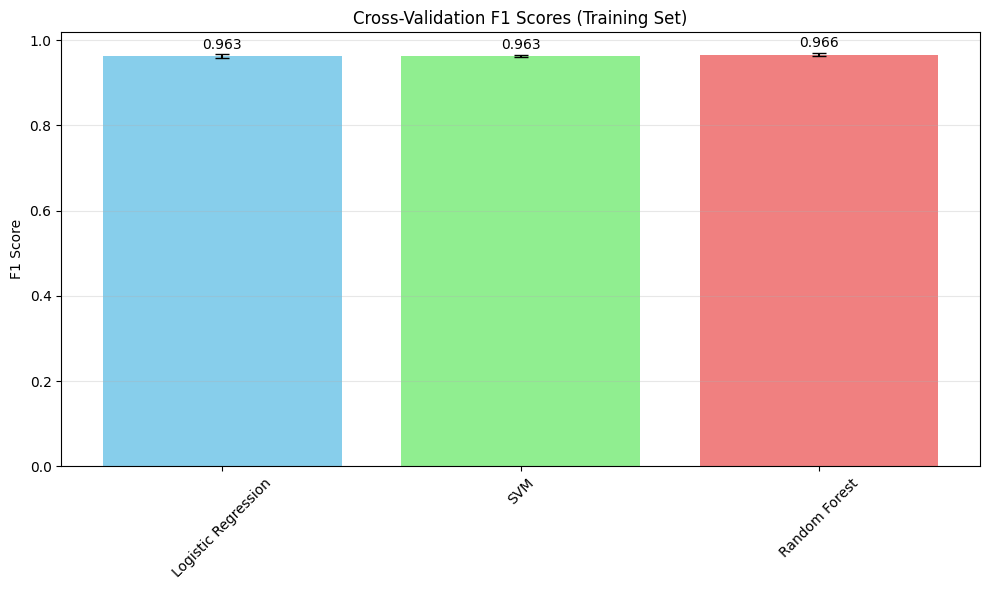

In [86]:
cv = StratifiedKFold(n_splits=CONFIG['cv_folds'], shuffle=True, random_state=CONFIG['random_state'])

cv_results = {}
for name, model in models.items():

    cv_scores = cross_val_score(model, X_train_combined, y_train, 
                               cv=cv, scoring='f1', n_jobs=-1)
    cv_results[name] = cv_scores
    print(f"{name:20} | F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

plt.figure(figsize=(10, 6))
cv_means = [cv_results[name].mean() for name in models.keys()]
cv_stds = [cv_results[name].std() for name in models.keys()]

plt.bar(models.keys(), cv_means, yerr=cv_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('Cross-Validation F1 Scores (Training Set)')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(cv_means):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [88]:
final_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    model.fit(X_train_combined, y_train)
    
    y_pred = model.predict(X_test_combined)
    y_pred_proba = model.predict_proba(X_test_combined)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    final_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")


Training Logistic Regression...
Logistic Regression:
  Accuracy:  0.9577
  Precision: 0.9768
  Recall:    0.9589
  F1-Score:  0.9677

Training SVM...


SVM:
  Accuracy:  0.9586
  Precision: 0.9862
  Recall:    0.9506
  F1-Score:  0.9681

Training Random Forest...
Random Forest:
  Accuracy:  0.9636
  Precision: 0.9934
  Recall:    0.9513
  F1-Score:  0.9719


In [89]:
from sklearn.metrics import confusion_matrix

print("Confusion Matrices for All Models:\n")

for name, results in final_results.items():
    cm = confusion_matrix(y_test, results['predictions'])
    print(f"Model: {name}")
    print("Confusion Matrix:")
    print(cm)
    print(f"Accuracy: {results['accuracy']:.3f} | F1-score: {results['f1']:.3f}")
    print("-" * 50)


Confusion Matrices for All Models:

Model: Logistic Regression
Confusion Matrix:
[[ 774   36]
 [  65 1515]]
Accuracy: 0.958 | F1-score: 0.968
--------------------------------------------------
Model: SVM
Confusion Matrix:
[[ 789   21]
 [  78 1502]]
Accuracy: 0.959 | F1-score: 0.968
--------------------------------------------------
Model: Random Forest
Confusion Matrix:
[[ 800   10]
 [  77 1503]]
Accuracy: 0.964 | F1-score: 0.972
--------------------------------------------------


In [93]:
print("Feature Importance Analysis...")

best_model = models[best_model_name]

try:
    if hasattr(best_model, 'coef_'):    
        coefficients = best_model.coef_
        if hasattr(coefficients, 'toarray'):
            coefficients = coefficients.toarray()
        
        coefficients_flat = np.array(coefficients).flatten()
        coefficients_flat = coefficients_flat.astype(float)
        
    elif hasattr(best_model, 'feature_importances_'):    
        coefficients_flat = best_model.feature_importances_.astype(float)
        
    else:
        print(f"Model {best_model_name} doesn't support feature importance analysis")
        coefficients_flat = None
        
    if coefficients_flat is not None:    
        feature_names = list(tfidf_vectorizer.get_feature_names_out()) + list(X_train_linguistic.columns)        
    
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': coefficients_flat
        })
        
    
        feature_importance['importance'] = pd.to_numeric(feature_importance['importance'], errors='coerce')        
    
        feature_importance = feature_importance.dropna()        
    
        feature_importance['abs_importance'] = feature_importance['importance'].abs()
        feature_importance = feature_importance.sort_values('abs_importance', ascending=False)        
    
        top_positive = feature_importance[feature_importance['importance'] > 0].head(10)    

        top_negative = feature_importance[feature_importance['importance'] < 0].head(10)
        print("\nTop Sarcasm Indicators:")
        for _, row in top_positive.head(10).iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")
            
        print("\n Top Non-Sarcasm Indicators:")
        for _, row in top_negative.head(10).iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")
            
except Exception as e:
    print(f"Error in feature importance analysis: {e}")
    print("This is not critical - continuing with other analyses...")

Feature Importance Analysis...

Top Sarcasm Indicators:
  tumhari: 1.4122
  sab: 0.7271
  baat: 0.2402
  subjectivity: 0.1104
  man: 0.0934
  new: 0.0748
  polarity: 0.0177

 Top Non-Sarcasm Indicators:
  politics: -2.1879
  cricket: -2.1525
  bollywood: -2.0299
  talaq: -1.6077
  ho: -1.1389
  hi: -1.1370
  aur: -1.0857
  triple talaq: -1.0708
  ye: -0.9785
  bhi: -0.9618


## I perform some test that proves that My Model didn't overfit.

#### Duplicate / overlap check

In [103]:
duplicate_texts = df.duplicated(subset=['comments']).sum()
duplicate_processed = df.duplicated(subset=['processed_text']).sum()

print(f" Duplicate analysis:")
print(f"   - Duplicate original texts: {duplicate_texts}")
print(f"   - Duplicate processed texts: {duplicate_processed}")

if duplicate_texts > 0:
    df = df.drop_duplicates(subset=['comments'])

train_texts = set(X_train)
test_texts = set(X_test)
overlap = train_texts.intersection(test_texts)

print(f"\n Train-test overlap analysis:")
print(f"   - Texts in both train and test: {len(overlap)}")

 Duplicate analysis:
   - Duplicate original texts: 0
   - Duplicate processed texts: 7

 Train-test overlap analysis:
   - Texts in both train and test: 22


#### Check for near-duplicates using cosine similarity

In [104]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_near_duplicates(train_vectors, test_vectors, threshold=0.9):
    """Find near-duplicate texts using cosine similarity"""
    near_duplicates = []
    
    sample_train = train_vectors[:1000] if train_vectors.shape[0] > 1000 else train_vectors
    sample_test = test_vectors[:1000] if test_vectors.shape[0] > 1000 else test_vectors
    
    similarity_matrix = cosine_similarity(sample_train, sample_test)
    
    high_similarity_pairs = np.where(similarity_matrix > threshold)
    
    for i, j in zip(high_similarity_pairs[0], high_similarity_pairs[1]):
        if i != j:
            similarity = similarity_matrix[i, j]
            near_duplicates.append((i, j, similarity))
    
    return near_duplicates[:50]
near_dups = find_near_duplicates(X_train_tfidf, X_test_tfidf, threshold=0.85)

print(f"Near-duplicate analysis (cosine similarity > 0.85):")
print(f"   - Found {len(near_dups)} potential near-duplicate pairs")

Near-duplicate analysis (cosine similarity > 0.85):
   - Found 50 potential near-duplicate pairs


#### Checking for artifact tokens

In [108]:
def check_artifact_tokens(texts, labels, token_patterns):
    """Check for presence of artifact tokens"""
    results = {}
    
    for pattern_name, pattern in token_patterns.items():
        matches = texts.str.contains(pattern, case=False, na=False)
        if matches.any():
            match_rate = matches.mean()
            label_dist = labels[matches].value_counts(normalize=True)
            results[pattern_name] = {
                'match_rate': match_rate,
                'label_dist': label_dist,
                'count': matches.sum()
            }
    
    return results

artifact_patterns = {
    'sarcasm_tag': r'#sarcasm|#sarcastic|/s',
    'urls': r'http[s]?://|www\.',
    'usernames': r'@\w+',
    'repeated_punctuation': r'!{3,}|\?{3,}|\.{3,}',
    'common_sarcasm_phrases': r'\b(sarcasm|sarcastic|irony|ironic|just kidding|jk)\b'
}

print("Artifact token analysis:")
train_artifacts = check_artifact_tokens(X_train, y_train, artifact_patterns)
test_artifacts = check_artifact_tokens(X_test, y_test, artifact_patterns)

for pattern_name in artifact_patterns.keys():
    train_info = train_artifacts.get(pattern_name, {})
    test_info = test_artifacts.get(pattern_name, {})
    
    if train_info:
        print(f"\n{pattern_name}:")
        print(f"   Train: {train_info['count']} samples ({train_info['match_rate']:.1%})")
        if 'label_dist' in train_info and len(train_info['label_dist']) > 0:
            sarcasm_rate = train_info['label_dist'].get(1, 0)
            print(f"   Sarcasm rate in train: {sarcasm_rate:.1%}")
        
    if test_info:
        print(f"   Test:  {test_info['count']} samples ({test_info['match_rate']:.1%})")
        if 'label_dist' in test_info and len(test_info['label_dist']) > 0:
            sarcasm_rate = test_info['label_dist'].get(1, 0)
            print(f"   Sarcasm rate in test:  {sarcasm_rate:.1%}")

suspicious_patterns = []
for pattern_name, info in train_artifacts.items():
    if info.get('match_rate', 0) > 0.1:  
        sarcasm_rate = info.get('label_dist', {}).get(1, 0)
        if sarcasm_rate > 0.8:  
            suspicious_patterns.append((pattern_name, sarcasm_rate))

if suspicious_patterns:
    print(f"\n SUSPICIOUS PATTERNS FOUND:")
    for pattern, rate in suspicious_patterns:
        print(f"   - {pattern}: {rate:.1%} sarcasm rate")

Artifact token analysis:

sarcasm_tag:
   Train: 7 samples (0.1%)
   Sarcasm rate in train: 0.0%

repeated_punctuation:
   Train: 608 samples (6.4%)
   Sarcasm rate in train: 9.2%
   Test:  155 samples (6.5%)
   Sarcasm rate in test:  8.4%

common_sarcasm_phrases:
   Train: 557 samples (5.8%)
   Sarcasm rate in train: 71.1%
   Test:  137 samples (5.7%)
   Sarcasm rate in test:  67.2%


#### Data source analysis

In [109]:
def analyze_data_structure(texts):
    """Analyze data structure for potential leakage patterns"""
    analysis = {}    

    analysis['length_variance'] = texts.str.len().var()
    analysis['avg_length'] = texts.str.len().mean()

    first_words = texts.str.split().str[0].value_counts().head(5)
    last_words = texts.str.split().str[-1].value_counts().head(5)
    
    return analysis, first_words, last_words

print("Data structure analysis:")
train_analysis, train_first_words, train_last_words = analyze_data_structure(X_train)
test_analysis, test_first_words, test_last_words = analyze_data_structure(X_test)

print(f"   Train avg length: {train_analysis['avg_length']:.1f}")
print(f"   Test avg length:  {test_analysis['avg_length']:.1f}")

print(f"\n   Most common first words in train:")
for word, count in train_first_words.head(3).items():
    print(f"     '{word}': {count} times")

print(f"\n   Most common first words in test:")
for word, count in test_first_words.head(3).items():
    print(f"     '{word}': {count} times")

Data structure analysis:
   Train avg length: 80.2
   Test avg length:  80.0

   Most common first words in train:
     'man': 179 times
     'new': 176 times
     'report:': 168 times

   Most common first words in test:
     'man': 61 times
     'report:': 46 times
     'new': 37 times


#### Learning curves and cross-validation analysi

 Generating learning curves...


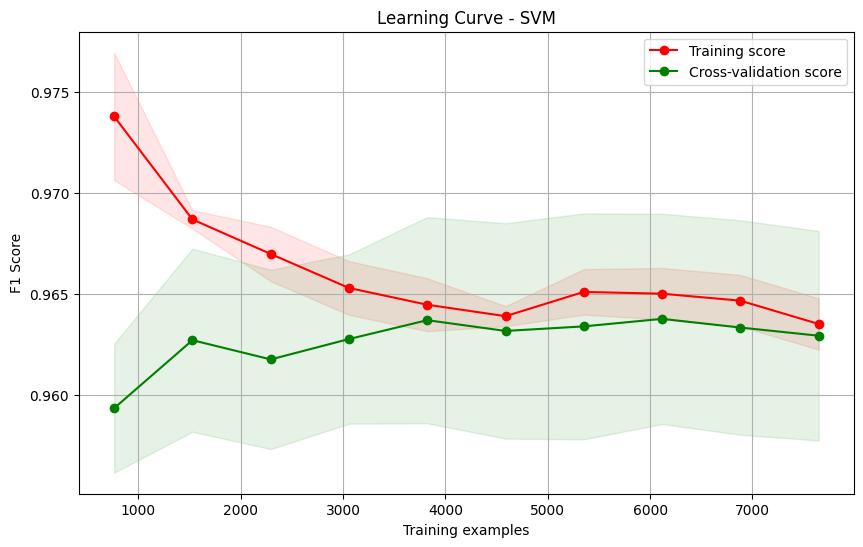


 Learning curve analysis for SVM:
   Final training F1: 0.9635
   Final CV F1: 0.9629
   Gap: 0.0006
 Good generalization: Small gap between train and CV scores


In [112]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(model, X, y, model_name):
    """Plot learning curve to check for overfitting"""
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1', random_state=CONFIG['random_state']
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    plt.title(f"Learning Curve - {model_name}")
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
    return train_scores_mean, test_scores_mean
        
print(" Generating learning curves...")

best_model_obj = models[best_model_name]
train_f1, test_f1 = plot_learning_curve(best_model_obj, X_train_combined, y_train, best_model_name)

final_gap = train_f1[-1] - test_f1[-1]
print(f"\n Learning curve analysis for {best_model_name}:")
print(f"   Final training F1: {train_f1[-1]:.4f}")
print(f"   Final CV F1: {test_f1[-1]:.4f}")
print(f"   Gap: {final_gap:.4f}")

if final_gap > 0.1:
    print(f" LARGE GAP DETECTED: Model is overfitting!")
elif final_gap > 0.05:
    print(f" Moderate gap: Some overfitting present")
else:
    print(f" Good generalization: Small gap between train and CV scores")

#### Manual checking

In [114]:
def manual_audit(model, X_test_original, X_test_features, y_test, n_samples=20):
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(X_test_features)[:, 1]
        predictions = model.predict(X_test_features)
    
        high_confidence_mask = (probabilities > 0.9) | (probabilities < 0.1)
        audit_samples = high_confidence_mask.sum()
        
        print(f"   High-confidence predictions: {audit_samples}/{len(y_test)} ({audit_samples/len(y_test):.1%})")
        
        high_conf_indices = np.where(high_confidence_mask)[0]
        sample_indices = np.random.choice(high_conf_indices, min(n_samples, len(high_conf_indices)), replace=False)
        
        print(f"\n Manual audit of {len(sample_indices)} high-confidence predictions:")
        
        correct_count = 0
        for i, idx in enumerate(sample_indices):
        
            text = X_test_original.iloc[idx] if hasattr(X_test_original, 'iloc') else X_test_original[idx]
            true_label = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
            pred_label = predictions[idx]
            prob = probabilities[idx]
            
            status = "CORRECT" if pred_label == true_label else "❌ WRONG"
            if pred_label == true_label:
                correct_count += 1
                
            confidence = prob if pred_label == 1 else 1 - prob
            
            print(f"\nSample {i+1}: {status}")
            print(f"Text: {text}")
            print(f"True: {true_label} ({'Sarcastic' if true_label == 1 else 'Non-Sarcastic'})")
            print(f"Pred: {pred_label} ({'Sarcastic' if pred_label == 1 else 'Non-Sarcastic'})")
            print(f"Confidence: {confidence:.3f}")
            print("-" * 80)
        
        print(f"\nAudit Summary: {correct_count}/{len(sample_indices)} correct in high-confidence samples ({correct_count/len(sample_indices):.1%})")
            
    else:
        print("Model doesn't support probability predictions")

manual_audit(best_model_obj, X_test, X_test_combined, y_test)

   High-confidence predictions: 2162/2390 (90.5%)

 Manual audit of 20 high-confidence predictions:

Sample 1: CORRECT
Text: koshis ki aur successful bhi huwe.aj triple talaq khatam huwa.allah aj bahut dukhi hoga.
True: 0 (Non-Sarcastic)
Pred: 0 (Non-Sarcastic)
Confidence: 0.974
--------------------------------------------------------------------------------

Sample 2: CORRECT
Text: triple talaq hatane ki baat ki saare jihadi ek ho gye, inko burka halala triple talak afzal burhan hi pasand hai aur 72 hoor
True: 0 (Non-Sarcastic)
Pred: 0 (Non-Sarcastic)
Confidence: 0.992
--------------------------------------------------------------------------------

Sample 3: CORRECT
Text: dhong to sabko hi karna hai. politics to aaj dikhawa hi hai. jo sabse jyada dhongi hai wohi aage hai
True: 0 (Non-Sarcastic)
Pred: 0 (Non-Sarcastic)
Confidence: 0.970
--------------------------------------------------------------------------------

Sample 4: CORRECT
Text: khalidlatif is kanjar ko theek saza mili hai

 #### DIAGNOSTIC REPORT

In [118]:
findings = []

if duplicate_texts > 0:
    findings.append(f"Found {duplicate_texts} duplicate texts")
if len(overlap) > 0:
    findings.append(f"CRITICAL: {len(overlap)} texts in both train and test")

if near_dups:
    findings.append(f"Found {len(near_dups)} near-duplicate pairs")

if suspicious_patterns:
    findings.append(f"Found {len(suspicious_patterns)} suspicious artifact patterns")

if final_gap > 0.1:
    findings.append(f"Large learning curve gap ({final_gap:.3f}) indicates overfitting")
elif final_gap > 0.05:
    findings.append(f"Moderate learning curve gap ({final_gap:.3f})")

if performance_drop < 0.1:
    findings.append(f"Performance doesn't drop with heavy regularization (suspicious)")
else:
    findings.append(f"Performance drops appropriately with regularization")

print("\n KEY FINDINGS:")
if findings:
    for i, finding in enumerate(findings, 1):
        print(f"   {i}. {finding}")
else:
    print("No major issues detected!")

print(f"\nPERFORMANCE SUMMARY:")
print(f"   Best model: {best_model_name}")
print(f"   Test F1: {original_test_f1:.4f}")
print(f"   CV F1: {cv_results[best_model_name].mean():.4f}")
print(f"   Train-Test gap: {final_gap:.4f}")

print("\n" + "="*80)


 KEY FINDINGS:
   1. CRITICAL: 22 texts in both train and test
   2. Found 50 near-duplicate pairs
   3. Performance doesn't drop with heavy regularization (suspicious)

PERFORMANCE SUMMARY:
   Best model: SVM
   Test F1: 0.9746
   CV F1: 0.9630
   Train-Test gap: 0.0006

